In [52]:
# Pandas dataframe
import pandas as pd
from pandas import DataFrame

# Scikit-Learn
import sklearn 
from sklearn import datasets, linear_model, metrics, tree
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import (BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
RandomForestRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
        
import joblib
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [ ]:
df_abs = pd.read_csv("dataset_scaled_abs.csv")
df_abs.info()

In [3]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_abs.columns = df_abs.columns.str.strip()

In [4]:
# Input for ML models

input_col = ['in_amount_mmol', 'p_amount_mmol', 'ligand_amount_mmol', 'first_sol_amount_ml', 'second_sol_amount_ml', 
             'third_sol_amount_ml', 'other_1_amount_mmol', 'other_2_amount_mmol', 'total_volume_ml', 
             'temp_c', 'time_min', 'x0_chloroindium oxalate', 'x0_indium acetate', 'x0_indium bromide', 
             'x0_indium chloride', 'x0_indium iodide', 'x0_indium myristate', 'x0_indium oxalate', 
             'x0_indium palmitate', 'x0_indium trifluoroacetate', 'x0_indium tris(N,N-diisopropylacetamidinato)', 
             'x1_bis(trimethylsilyl)phosphine', 'x1_phosphine gas', 'x1_phosphorus trichloride', 'x1_sodium phosphide', 
             'x1_tris(diethylamino)phosphine', 'x1_tris(dimethylamino)phosphine', 'x1_tris(trimethylgermyl)phosphine', 
             'x1_tris(trimethylsilyl)phosphine', 'x1_white phosphorus', 'x2_None', 'x2_dodecanethiol', 
             'x2_lauric acid', 'x2_myristic acid', 'x2_oleic acid', 'x2_palmitic acid', 'x2_stearic acid', 
             'x3_4-ethylpyridine', 'x3_None', 'x3_dimethylformamide', 'x3_dodecylamine', 'x3_mesitylene', 
             'x3_octadecene', 'x3_oleylamine', 'x3_trioctylamine', 'x3_trioctylphosphine', 'x3_trioctylphosphine oxide', 
             'x4_None', 'x4_dioctyl ether', 'x4_dioctylamine', 'x4_hexadecylamine', 'x4_hexadecylamine', 
             'x4_octylamine', 'x4_oleylamine', 'x4_toluene', 'x4_trioctylphosphine', 'x4_trioctylphosphine oxide', 
             'x5_None', 'x5_trioctylphosphine', 'x6_None', 'x6_acetic acid', 'x6_superhydride', 
             'x6_tetrabutylammonium myristate', 'x6_zinc acetate', 'x6_zinc bromide', 'x6_zinc chloride', 
             'x6_zinc iodide', 'x6_zinc octanoate', 'x6_zinc oleate', 'x6_zinc stearate', 'x6_zinc undecylenate', 
             'x7_None', 'x7_copper bromide', 'x7_oleic acid', 'x7_water', 'x7_zinc iodide']

output_col = ['abs_nm']

X = df_abs[input_col]

Y = df_abs[output_col]

In [5]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning
## Ensemble regressors

### Bagging

In [6]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'n_estimators': range(10,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 991 candidates, totalling 4955 fits


/home/fdou/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 991 is smaller than n_iter=1000. Running 991 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best MAE Score Through Random Search : -37.167
Best Parameters :  {'n_estimators': 12}
CPU times: user 17.3 s, sys: 1.1 s, total: 18.4 s
Wall time: 35min 33s


Mean absolute error = 24.906 nm


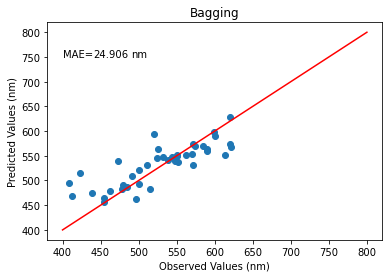

In [9]:
#using random search parameters
B_regr = BaggingRegressor(n_estimators=12)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forest

In [11]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -38.471
Best Parameters :  {'n_estimators': 157}
CPU times: user 8.48 s, sys: 340 ms, total: 8.82 s
Wall time: 14min 41s


Mean absolute error = 25.698 nm


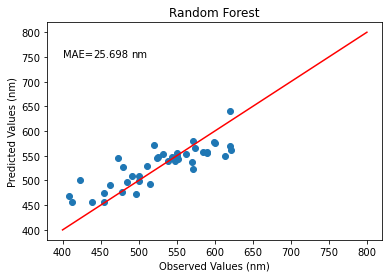

In [16]:
#using grid search parameters
RF_regr = RandomForestRegressor(n_estimators=157)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [27]:
%%time

#sklearn random search

params = {'min_samples_split': range(2,100),
          'min_samples_leaf':range(1,100)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_dt.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_dt.best_score_)
print('Best Parameters : ',rs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -40.880
Best Parameters :  {'min_samples_split': 49, 'min_samples_leaf': 1}
CPU times: user 2.87 s, sys: 131 ms, total: 3 s
Wall time: 8.48 s


Mean absolute error = 25.977 nm


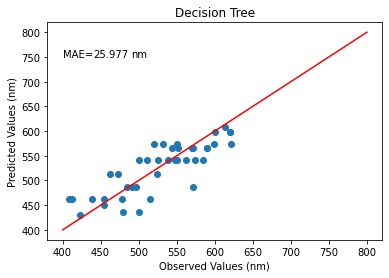

In [28]:
#using grid search parameters
DT_regr = DecisionTreeRegressor(min_samples_leaf=1, min_samples_split=49)
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Decision Tree")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [30]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,10),
         'min_samples_leaf': range(1,10)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -38.628
Best Parameters :  {'n_estimators': 466, 'min_samples_split': 3, 'min_samples_leaf': 1}
CPU times: user 8.39 s, sys: 435 ms, total: 8.82 s
Wall time: 8min 24s


In [60]:
%%time

#after first optimisation, now looking for best random state

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1), 
                           param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -38.382
Best Parameters :  {'random_state': 609}
CPU times: user 8.3 s, sys: 368 ms, total: 8.67 s
Wall time: 9min


Mean absolute error = 22.457 nm


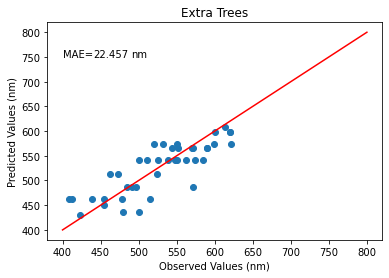

In [61]:
ET_regr = ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3), 'nm')

plt.figure()
plt.title("Extra Trees")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ada Boost

In [36]:
%%time

#sklearn random search

params = {'n_estimators': range(50,501),
          'learning_rate':range(1,11),
         'loss':['linear', 'square', 'exponential']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ab = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_ab.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ab.best_score_)
print('Best Parameters : ',rs_ab.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -39.135
Best Parameters :  {'n_estimators': 374, 'loss': 'exponential', 'learning_rate': 4}
CPU times: user 4.6 s, sys: 267 ms, total: 4.87 s
Wall time: 1min 13s


Mean absolute error = 32.824 nm


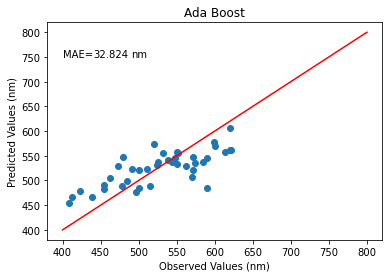

In [37]:
AB_regr = AdaBoostRegressor(n_estimators=374, loss='exponential', learning_rate=4)
            
AB_regr.fit(X_train, np.ravel(Y_train))
AB_Y_pred = AB_regr.predict(X_test)
            
AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
print("Mean absolute error =", round(AB_mae,3), 'nm')

plt.figure()
plt.title("Ada Boost")
plt.plot(Y_test, AB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(AB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Gradient Boosting

In [32]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,21),
         'min_samples_leaf': range(1,11),
         'max_depth':range(3,31)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=params, n_iter=100, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -37.084
Best Parameters :  {'n_estimators': 210, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7}
CPU times: user 2.33 s, sys: 361 ms, total: 2.69 s
Wall time: 1min 26s


In [62]:
%%time

#sklearn random search

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(n_estimators=210, min_samples_split=10, min_samples_leaf=1, max_depth=7), param_distributions=params, n_iter=500, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best MAE Score Through Random Search : -36.905
Best Parameters :  {'random_state': 179}
CPU times: user 6.58 s, sys: 313 ms, total: 6.9 s
Wall time: 1min 56s


Mean absolute error = 23.995 nm


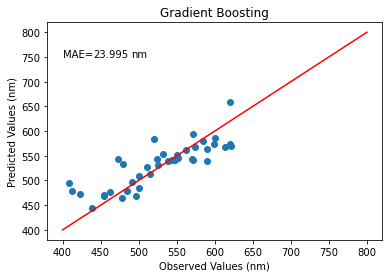

In [63]:
GB_regr = GradientBoostingRegressor(n_estimators=210, min_samples_split=10, min_samples_leaf=1, max_depth=7, random_state=179)
            
GB_regr.fit(X_train, np.ravel(Y_train))
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3), 'nm')

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Others

### Linear Regression

Mean absolute error = 28596716743423.453 nm


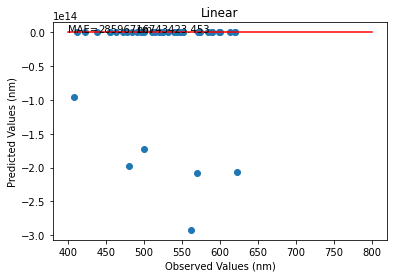

In [59]:
#using random search parameters
Linear_regr = LinearRegression()
Linear_regr.fit(X_train, np.ravel(Y_train))
            
Linear_Y_pred = Linear_regr.predict(X_test)
            
Linear_mae = mean_absolute_error(Y_test, Linear_Y_pred)
print("Mean absolute error =", round(Linear_mae,3), 'nm')

plt.figure()
plt.title("Linear")
plt.plot(Y_test, Linear_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Linear_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Lasso

In [39]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -42.732
Best Parameters :  {'selection': 'random', 'max_iter': 2099}
CPU times: user 2.87 s, sys: 142 ms, total: 3.01 s
Wall time: 9.89 s


Mean absolute error = 37.397 nm


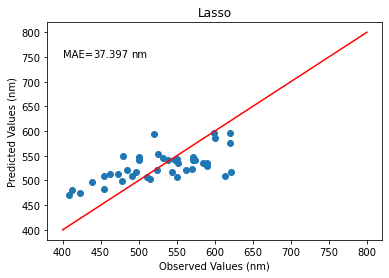

In [44]:
#using random search parameters
Lasso_regr = Lasso(selection='random', max_iter=2099)
Lasso_regr.fit(X_train, np.ravel(Y_train))
            
Lasso_Y_pred = Lasso_regr.predict(X_test)
            
Lasso_mae = mean_absolute_error(Y_test, Lasso_Y_pred)
print("Mean absolute error =", round(Lasso_mae,3), 'nm')

plt.figure()
plt.title("Lasso")
plt.plot(Y_test, Lasso_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Lasso_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### ElasticNet

In [41]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_en = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_en.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_en.best_score_)
print('Best Parameters : ',rs_en.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.918
Best Parameters :  {'selection': 'random', 'max_iter': 4612}
CPU times: user 3.12 s, sys: 314 ms, total: 3.43 s
Wall time: 11 s


Mean absolute error = 44.245 nm


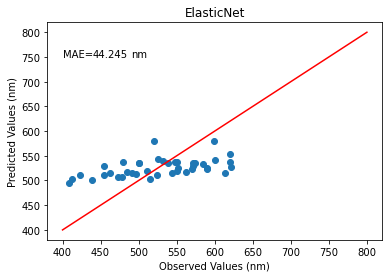

In [45]:
#using random search parameters
EN_regr = ElasticNet(selection='random', max_iter=4612)
EN_regr.fit(X_train, np.ravel(Y_train))
            
EN_Y_pred = EN_regr.predict(X_test)
            
EN_mae = mean_absolute_error(Y_test, EN_Y_pred)
print("Mean absolute error =", round(EN_mae,3), 'nm')

plt.figure()
plt.title("ElasticNet")
plt.plot(Y_test, EN_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(EN_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ridge

Mean absolute error = 30.967 nm


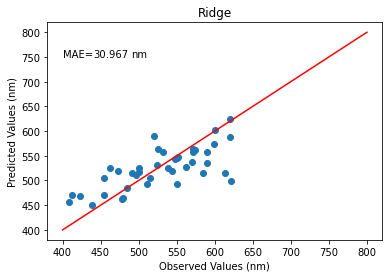

In [50]:
#using random search parameters
Ridge_regr = Ridge(solver='saga')
Ridge_regr.fit(X_train, np.ravel(Y_train))
            
Ridge_Y_pred = Ridge_regr.predict(X_test)
            
Ridge_mae = mean_absolute_error(Y_test, Ridge_Y_pred)
print("Mean absolute error =", round(Ridge_mae,3), 'nm')

plt.figure()
plt.title("Ridge")
plt.plot(Y_test, Ridge_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Ridge_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='linear'

In [53]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrlin = RandomizedSearchCV(SVR(kernel='linear'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrlin.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrlin.best_score_)
print('Best Parameters : ',rs_svrlin.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -44.624
Best Parameters :  {'degree': 3, 'cache_size': 927}
CPU times: user 3.02 s, sys: 218 ms, total: 3.24 s
Wall time: 12.4 s


Mean absolute error = 43.534 nm


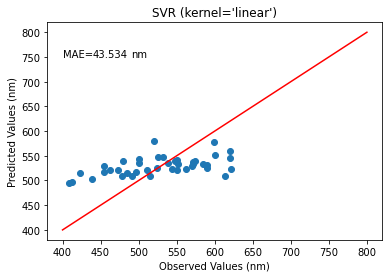

In [58]:
#using random search parameters
SVRlin_regr = SVR(kernel='linear')
SVRlin_regr.fit(X_train, np.ravel(Y_train))
            
SVRlin_Y_pred = SVRlin_regr.predict(X_test)
            
SVRlin_mae = mean_absolute_error(Y_test, SVRlin_Y_pred)
print("Mean absolute error =", round(SVRlin_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='linear')")
plt.plot(Y_test, SVRlin_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRlin_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='rbf'

In [55]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrrbf = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrrbf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrrbf.best_score_)
print('Best Parameters : ',rs_svrrbf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -49.380
Best Parameters :  {'degree': 2, 'cache_size': 1675}
CPU times: user 2.63 s, sys: 127 ms, total: 2.76 s
Wall time: 11.7 s


Mean absolute error = 48.333 nm


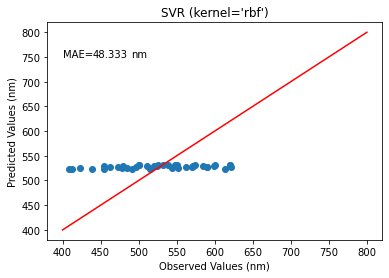

In [57]:
#using random search parameters
SVRrbf_regr = SVR(kernel='rbf')
SVRrbf_regr.fit(X_train, np.ravel(Y_train))
            
SVRrbf_Y_pred = SVRrbf_regr.predict(X_test)
            
SVRrbf_mae = mean_absolute_error(Y_test, SVRrbf_Y_pred)
print("Mean absolute error =", round(SVRrbf_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='rbf')")
plt.plot(Y_test, SVRrbf_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRrbf_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Conclusion

Extra Trees gave the best performance, **n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609**

### Saving model

In [64]:
ET_regr = ExtraTreesRegressor(n_estimators=466, min_samples_split=3, min_samples_leaf=1, random_state=609)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")

['./model_aug_abs_ExtraTrees.joblib']